# Optimization IOU and Confidence over SSD300

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
import json
import os.path

from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

# from models.keras_ssd300 import ssd_300
from models.keras_ssd300_mobilenetv1_imagenet import ssd_300
from models.keras_ssd512 import ssd_512
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

from extra_files import helper

Using TensorFlow backend.
/home/aldo/Documents/ssd/data_generator/object_detection_2d_data_generator.py:43: UserWarning: 'BeautifulSoup' module is missing. The XML-parser will be unavailable.
  warnings.warn("'BeautifulSoup' module is missing. The XML-parser will be unavailable.")


## 1. Load a trained SSD

### Build the model and load trained weights into it wih parameters confidence and iou threshold

In [2]:
# model_pascal_voc_07_plus_12_300x300 = '../weights/pascal_voc/pascal_voc_07_12_coco_300x300.h5'

In [3]:
# model = ssd_300(image_size=(300, 300, 3),
#                 n_classes=20,
#                 mode='training',
#                 l2_regularization=0.0005,
#                 scales=[0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05],
#                 aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
#                                          [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
#                                          [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
#                                          [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
#                                          [1.0, 2.0, 0.5],
#                                          [1.0, 2.0, 0.5]],
#                 two_boxes_for_ar1=True,
#                 steps=[8, 16, 32, 64, 100, 300],
#                 offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
#                 clip_boxes=False,
#                 variances=[0.1, 0.1, 0.2, 0.2],
#                 normalize_coords=True,
#                 subtract_mean=[123, 117, 104],
#                 swap_channels=[2, 1, 0],
#                 confidence_thresh=0.0,
#                 iou_threshold=0.0,
#                 top_k=9000,
#                 nms_max_output_size=9000)

# # 2: Load the trained weights into the model.
# # TODO: Set the path of the trained weights.
# model.load_weights(model_pascal_voc_07_plus_12_300x300, by_name=True)

# # 3: Compile the model so that Keras won't complain the next time you load it.

# adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

# model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [4]:
## Parameteres needed for ssd_300() and SSDInputEncoder()

img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [-1., -1., -1.] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
divide_by_stddev = [127.5, 127.5, 127.5]
swap_channels = False # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
new_scales = [0.15, 0.33, 0.47, 0.61, 0.76, 0.90, 1.05]
scales = new_scales
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [16, 30, 60, 100, 150, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

In [5]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(300, 300, img_channels),
                n_classes=n_classes,
                mode='training',
                alpha=1.0,
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

# 2: Load some weights into the model.

# TODO: Set the path to the weights you want to load.
weights_path = '../weights/models/ssd_mobilenetv1/ssd300_mobilenetv1_imagenet_cic.h5'
model.load_weights(weights_path, by_name=True)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

  ## 2. Load Images

Load some images for which you'd like the model to make predictions.

In [6]:
path_root = '/home/aldo/Documents/data-cic/preprocess_data'
path_save = path_root + '/predictions/'
train_img = np.load(path_root + '/images_train_300x300.npy')

## 3. Make predictions

In [7]:
# model_pascal_voc_07_plus_12_300x300 = '../weights/pascal_voc/pascal_voc_07_12_coco_300x300.h5'

In [8]:
def get_predictions(model, batch_size, images_list, confidence, iou):
    '''
    Make predictions from a model
    path_model: the path to the weights' model
    batch_size: size of the batch
    images_list: list of images to make predictions
    confidence: confidence threshold
    iou: iou threshold
    return predictions
    '''
    # Create variable to store predictions
    predictions = []
    
    for batch in helper.get_batch(batch_size, images_list):
        pred = model.predict(batch)
        y_decoded = decode_detections(pred,
                                      confidence_thresh=confidence,
                                      iou_threshold=iou,
                                      top_k=200,
                                      normalize_coords=False,
                                      img_height=300, 
                                      img_width=300)
        for bb in y_decoded:
            predictions.append(bb)
    predictions = np.array(predictions)
    clean_pre = helper.clean_predictions(predictions, id_class=1)
    adjust_pre = helper.adjust_predictions(clean_pre)
    return adjust_pre

In [10]:
# Make predictions of the models
# pascal 07+12+coco
predictions_list = []
confidence_list = np.arange(0.05, 1.0, 0.05)
iou_list= np.arange(0.2, 0.55, 0.05)

columns = ['Conficence', 'IOU', 'Predictions']

for conf in confidence_list:
    for iou in iou_list:
        print('Predictions with confidence: ', conf, ' iou: ', iou)
        start = time.time()

        pred = get_predictions(model, 32, train_img, conf.item(), iou.item())
        predictions_list.append(np.array([conf, iou, pred]))
        
        end = time.time()
        print(round(end - start, 4))

predictions_list = np.array(predictions_list)

# Create DataFrame with all predictions
pred_data = pd.DataFrame(predictions_list, columns=columns)

# Save data
np.save(path_save + 'optimization_pred', predictions_list)

Predictions with confidence:  0.05  iou:  0.2
0.7011
Predictions with confidence:  0.05  iou:  0.25
0.6881
Predictions with confidence:  0.05  iou:  0.3
0.7549
Predictions with confidence:  0.05  iou:  0.35
0.7714
Predictions with confidence:  0.05  iou:  0.39999999999999997
0.7488
Predictions with confidence:  0.05  iou:  0.44999999999999996
0.6885
Predictions with confidence:  0.05  iou:  0.49999999999999994
0.6894
Predictions with confidence:  0.1  iou:  0.2
0.6761
Predictions with confidence:  0.1  iou:  0.25
0.6808
Predictions with confidence:  0.1  iou:  0.3
0.6791
Predictions with confidence:  0.1  iou:  0.35
0.6768
Predictions with confidence:  0.1  iou:  0.39999999999999997
0.6789
Predictions with confidence:  0.1  iou:  0.44999999999999996
0.6769
Predictions with confidence:  0.1  iou:  0.49999999999999994
0.6769
Predictions with confidence:  0.15000000000000002  iou:  0.2
0.6727
Predictions with confidence:  0.15000000000000002  iou:  0.25
0.6735
Predictions with confidence:

0.665
Predictions with confidence:  0.9000000000000001  iou:  0.49999999999999994
0.6581
Predictions with confidence:  0.9500000000000001  iou:  0.2
0.6733
Predictions with confidence:  0.9500000000000001  iou:  0.25
0.6633
Predictions with confidence:  0.9500000000000001  iou:  0.3
0.6677
Predictions with confidence:  0.9500000000000001  iou:  0.35
0.7187
Predictions with confidence:  0.9500000000000001  iou:  0.39999999999999997
0.7153
Predictions with confidence:  0.9500000000000001  iou:  0.44999999999999996
0.7236
Predictions with confidence:  0.9500000000000001  iou:  0.49999999999999994
0.6784


## Some predictions with different confidence and iou

In [8]:
preds = helper.get_coordinates(pred_data.iloc[200]['Predictions'])

In [9]:
one_pred = helper.normilize_to_pixel(preds, 300, 300)

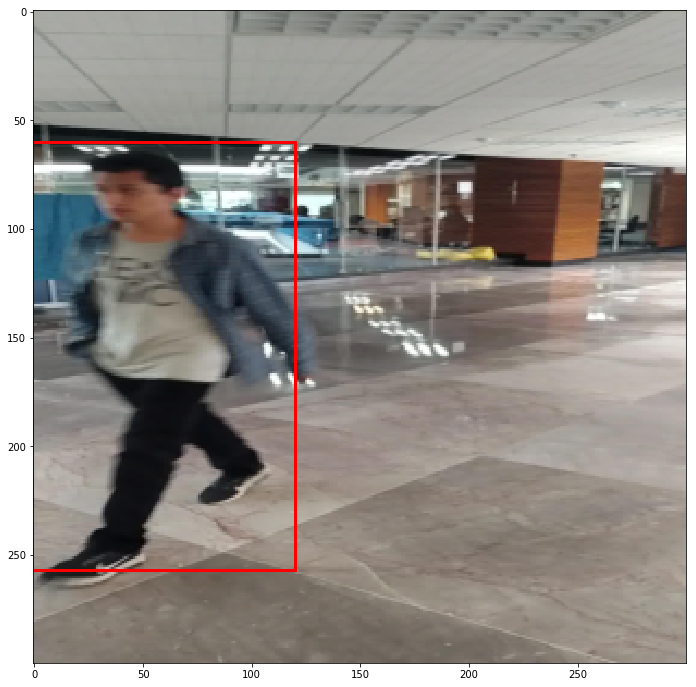

In [10]:
helper.show_image_bb(train_img[115], one_pred[115])

## Search for optimal parameters by calculating f1 score

In [5]:
columns = ['Conficence', 'IOU', 'Predictions']
pred_data  = np.load(path_save + 'optimization_pred.npy')
pred_data = pd.DataFrame(pred_data, columns=columns)
pred_data.head()

,Conficence,IOU,Predictions
0,0.05,0.05,"[[[15.0, 0.325174480676651, 0.6062076091766357..."
1,0.05,0.1,"[[[15.0, 0.325174480676651, 0.6062076091766357..."
2,0.05,0.15,"[[[15.0, 0.325174480676651, 0.6062076091766357..."
3,0.05,0.2,"[[[15.0, 0.325174480676651, 0.6062076091766357..."
4,0.05,0.25,"[[[15.0, 0.325174480676651, 0.6062076091766357..."


In [11]:
label_training = np.load(path_root + '/label_train.npy')

In [12]:
# Iterate over all predictions and calculate the metrics
performance = []

for idx_pred in list(range(pred_data.shape[0])):
    print('Calculating metrics for:', idx_pred + 1, 'from:', pred_data.shape[0])
    
    pred = pred_data.iloc[idx_pred]['Predictions']
    pred = helper.get_coordinates(pred)
    confidence = pred_data.iloc[idx_pred]['Conficence']
    iou = pred_data.iloc[idx_pred]['IOU']
    # Calculate metrics
    presicion, recall, f1_score = helper.cal_performance(label_training, pred, False)
    performance.append([confidence, iou, presicion, recall, f1_score])

# Create DataFrame with all metrics
columns = ['Confidence', 'IOU', 'Precisión', 'Recall', 'F1 score']
performance_frame = pd.DataFrame(np.array(performance), columns=columns)

Calculating metrics for: 1 from: 133
Calculating metrics for: 2 from: 133
Calculating metrics for: 3 from: 133
Calculating metrics for: 4 from: 133
Calculating metrics for: 5 from: 133
Calculating metrics for: 6 from: 133
Calculating metrics for: 7 from: 133
Calculating metrics for: 8 from: 133
Calculating metrics for: 9 from: 133
Calculating metrics for: 10 from: 133
Calculating metrics for: 11 from: 133
Calculating metrics for: 12 from: 133
Calculating metrics for: 13 from: 133
Calculating metrics for: 14 from: 133
Calculating metrics for: 15 from: 133
Calculating metrics for: 16 from: 133
Calculating metrics for: 17 from: 133
Calculating metrics for: 18 from: 133
Calculating metrics for: 19 from: 133
Calculating metrics for: 20 from: 133
Calculating metrics for: 21 from: 133
Calculating metrics for: 22 from: 133
Calculating metrics for: 23 from: 133
Calculating metrics for: 24 from: 133
Calculating metrics for: 25 from: 133
Calculating metrics for: 26 from: 133
Calculating metrics f

In [13]:
performance_frame.head()

,Confidence,IOU,Precisión,Recall,F1 score
0,0.05,0.20,0.584504,0.699403,0.636812
1,0.05,0.25,0.580190,0.713164,0.639841
2,0.05,0.30,0.572312,0.715860,0.636088
3,0.05,0.35,0.565811,0.721562,0.634265
4,0.05,0.40,0.558529,0.729661,0.632728


In [14]:
performance_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 5 columns):
Confidence    133 non-null float64
IOU           133 non-null float64
Precisión     133 non-null float64
Recall        133 non-null float64
F1 score      133 non-null float64
dtypes: float64(5)
memory usage: 5.3 KB


In [15]:
performance_frame.describe()

,Confidence,IOU,Precisión,Recall,F1 score
count,133.000000,133.000000,133.000000,133.000000,133.000000
mean,0.500000,0.350000,0.791586,0.538948,0.627805
std,0.274897,0.100378,0.063535,0.120245,0.077665
min,0.050000,0.200000,0.547733,0.276830,0.418486
25%,0.250000,0.250000,0.781128,0.454600,0.587322
50%,0.500000,0.350000,0.805993,0.551887,0.641566
75%,0.750000,0.450000,0.828886,0.634524,0.693765
max,0.950000,0.500000,0.857440,0.735395,0.717979


In [16]:
print(performance_frame.iloc[performance_frame['Precisión'].argmax()], end='\n\n')
print(performance_frame.iloc[performance_frame['Recall'].argmax()], end='\n\n')
print(performance_frame.iloc[performance_frame['F1 score'].argmax()], end='\n\n')

Confidence    0.950000
IOU           0.300000
Precisión     0.857440
Recall        0.279866
F1 score      0.421995
Name: 128, dtype: float64

Confidence    0.050000
IOU           0.500000
Precisión     0.547733
Recall        0.735395
F1 score      0.627841
Name: 6, dtype: float64

Confidence    0.150000
IOU           0.400000
Precisión     0.751336
Recall        0.687457
F1 score      0.717979
Name: 18, dtype: float64



/home/aldo/anaconda3/envs/test2/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.
/home/aldo/anaconda3/envs/test2/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  
/home/aldo/anaconda3/envs/test2/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  This is separate from the ipykern

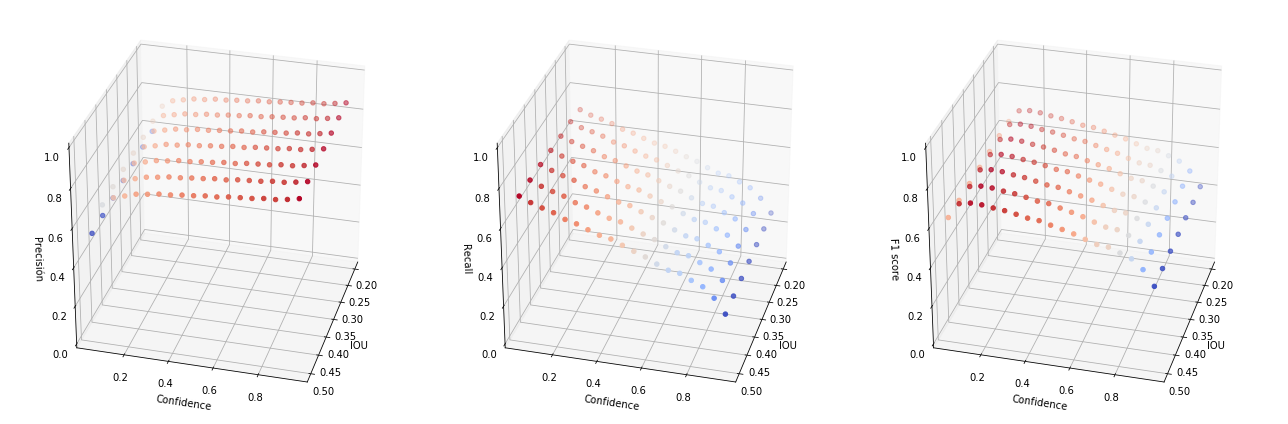

In [17]:
import seaborn as sns
presicion = performance_frame['Precisión']
recall =  performance_frame['Recall']
f1_score = performance_frame['F1 score']
iou = performance_frame['IOU']
confidence = performance_frame['Confidence']

fig = plt.figure(figsize=(18,6))

# fig = plt.figure()
ax = fig.add_subplot(131, projection='3d')
ax.scatter(iou, confidence, presicion, c=presicion, cmap='coolwarm', linewidth=1.0)
ax.set_zlim(0, 1)
ax.set_xlabel('IOU')
ax.set_ylabel('Confidence')
ax.set_zlabel('Precisión')
ax.view_init(30, 15)
# ax.plot_trisurf(iou, confidence, f1_score)

ax = fig.add_subplot(132, projection='3d')
ax.scatter(iou, confidence, recall, c=recall, cmap='coolwarm', linewidth=1.0)
ax.set_zlim(0, 1)
ax.set_xlabel('IOU')
ax.set_ylabel('Confidence')
ax.set_zlabel('Recall')
ax.view_init(30, 15)


ax = fig.add_subplot(133, projection='3d')
ax.scatter(iou, confidence, f1_score, c=f1_score, cmap='coolwarm', linewidth=1.0)
ax.set_zlim(0, 1)
ax.set_xlabel('IOU')
ax.set_ylabel('Confidence')
ax.set_zlabel('F1 score')
ax.view_init(30, 15)


fig.tight_layout()